In [1]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Folders
projpath  = os.path.realpath("..")
pathadmix = os.path.join(projpath, "DataBases", "Genotypes", "Admixture")
pathref   = os.path.join(projpath, "DataBases", "Genotypes")
pathres   = os.path.join(projpath, "Results")

#Read data
os.chdir(pathadmix)
qfiles  = glob.glob("*.Q") #all Q files to read
list_ks = []
for i in qfiles:
    list_ks.append(int(i.split(".")[1])) #Get number of ks per file
 
list_ks = np.array(list_ks) #To np array
sorted_index  = np.argsort(list_ks) #sort and keep indices
qfiles     = [ qfiles[i] for i in sorted_index] #Sort based on indices
admixfiles = []
for i in qfiles:
    file = pd.read_csv(i, sep = " ", header=None)
    admixfiles.append(file)

pop_admix =  pd.read_csv("geno.fam",  sep = " ", header=None)
pop_admix.columns = [0, 'ID', 2, 3, 4, 5]

#Reading reference pop info
os.chdir(pathref)
pop_ref  = pd.read_csv("RefPops.csv", sep=",")

#Reading common IDs across databases
os.chdir(pathres)
pop_adapt = pd.read_csv("common_ids.txt", header=None)


In [2]:
#Dividing in reference and not reference samples
ref_bool = pop_admix['ID'].isin(pop_ref['ID'])
ref_ind  = [i for i, x in enumerate(ref_bool) if x]
adp_bool = pop_admix['ID'].isin(pop_adapt[0])
adp_ind  = [i for i, x in enumerate(adp_bool) if x]
admix_adapt = []
admix_ref   = []
for i in range(len(admixfiles)):
    #For reference samples
    new_ref = admixfiles[i].loc[ref_ind,:].reset_index(drop=True)
    admix_ref.append(new_ref)
    #For adapt samples
    new_adapt = admixfiles[i].loc[adp_ind,:].reset_index(drop=True)
    admix_adapt.append(new_adapt)

#Generating new pop files, based on previous division
new_pop_admix = pop_admix.loc[ref_ind,:].reset_index(drop=True)
new_pop_ref = pd.merge(new_pop_admix, pop_ref, on='ID', how='left')[['ID', 'pop', 'super_pop']]

In [3]:
#Definition of set of functions
#First, organize figure in terms of number of Qfiles. 
#Then, for each Qfile, create its corresponding axis, already sorted 
#Try to keep only one sorting options across ks
#Finally, add text to figures

def sort_qfile(Qfile_unsorted):
    #Function to sort Qfiles
    #If pop column exist, then sort first by pop, and super_pop, and then by ks. This will also return the position of pop and super pop labels
    #If pop column does not exist, then sort only by ks
    import pandas as pd
    import numpy as np
    
    Qfile_sorted       = pd.DataFrame()
    Qfile_sort_indices = pd.Series()
    
    if 'pop' in Qfile_unsorted.columns:
        sortpops = ['super_pop', 'pop']
        Qfile_sorted_initial = Qfile_unsorted.sort_values(by = sortpops)
        list_superpop = Qfile_sorted_initial['super_pop'].unique()
        list_pop      = Qfile_sorted_initial['pop'].unique()
        loc_superpop  = []
        loc_pop       = []
        for l in list_superpop:
            #Getting location of superpop with respect to data
            pop_bool = Qfile_sorted_initial['super_pop'] == l
            pop_ind  = [i for i, x in enumerate(pop_bool) if x]
            loc_lab  = ( min(pop_ind) + max(pop_ind) ) / 2
            loc_superpop.append(loc_lab)
        for l in list_pop:
            #Getting location of pop with respect to data
            pop_bool = Qfile_sorted_initial['pop'] == l
            pop_ind  = [i for i, x in enumerate(pop_bool) if x]
            loc_lab  = ( min(pop_ind) + max(pop_ind) ) / 2
            loc_pop.append(loc_lab)
                  
            #Sorting each pop by highest k, and then the remaining ones
            group      = Qfile_sorted_initial.iloc[pop_ind,:]
            sortingby  = [i[0] for i in sorted(enumerate(group.mean()), reverse=True, key=lambda x:x[1])] #Sort by most to least relevant cluster
            indices    = pd.Series(group.sort_values(by = sortingby).index)
            group      = group.sort_values(by = sortingby).reset_index(drop=True)
            Qfile_sorted = pd.concat([Qfile_sorted, group])
            Qfile_sort_indices = Qfile_sort_indices.append(indices)
            
        return(Qfile_sorted, Qfile_sort_indices, loc_superpop, loc_pop, list_superpop, list_pop)
    
    elif 'pop' not in Qfile_unsorted.columns:
        ks = Qfile_unsorted.shape[1] #Number of groups
        cols_to_group = Qfile_unsorted.idxmax(axis=1) #Create list of column with highest value per row
        for i in range(ks):
            #Sorting individuals by separating them in their k with highest proportion, and sorting by the other ks next
            #We'll paste them together to create a new sorted dataframe
            group      = Qfile_unsorted[cols_to_group == i]
            sortingby  = [i[0] for i in sorted(enumerate(group.mean()), reverse=True, key=lambda x:x[1])] #Sort by most to least relevant cluster
            indices    = pd.Series(group.sort_values(by = sortingby).index)
            group      = group.sort_values(by = sortingby).reset_index(drop=True)
            Qfile_sorted = pd.concat([Qfile_sorted, group])
            Qfile_sort_indices = Qfile_sort_indices.append(indices)
        
        return(Qfile_sorted, Qfile_sort_indices)
        
def plot_admix(Qfiles, popfile=None, sort_by_k = None):
    # Figure to plot admixture files
    # Qfiles can be either a list of pandas Dataframes containing the Q proportions
    # or a single file
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    width = 1   
    
    if isinstance(Qfiles, list): #if there is a list of pandas dataframes
        qs     = len(Qfiles)
        fig    = plt.figure(figsize=(40, 2*qs), dpi=100)
        loc_ks = 1/qs/2
        #Doing sorting in here, keep the same sort across ks
        if popfile is not None:
            #Sort samples based on known populations and ks from last list
            Qfile = pd.concat([Qfiles[qs-1], popfile], axis = 1)
            Qfile_sorted, Qfile_sort_indices, loc_superpop, loc_pop, list_superpop, list_pop = sort_qfile(Qfile)
        if popfile is None:
            if sort_by_k is None:
                sort_by_k = qs - 1                   
            Qfile_sorted, Qfile_sort_indices = sort_qfile(Qfiles[sort_by_k])
            
        for i in range(qs):
            Qfile = Qfiles[i].loc[Qfile_sort_indices,:]
            ks    = Qfile.shape[1]
            ind   = np.arange(Qfile.shape[0]) #Number of samples
            ax    = fig.add_subplot(qs, 1, i+1)
            for l in range(ks):
                this_stack = Qfile[l]
                if l > 0:
                    bottom_stack = Qfile.iloc[:,0:l].sum(axis=1)
                else:
                    bottom_stack = None
                ax.bar(ind, this_stack, bottom = bottom_stack,width = width) 
                plt.axis('off')
                ax.autoscale(tight=True)
            if i == 0 and popfile is not None:
                #if first plot, draw the super_pop legends
                for l in range(len(loc_superpop)):
                    plt.text(loc_superpop[l], 1.2, list_superpop[l], fontsize=18)
            if i == (qs-1) and popfile is not None:
                for l in range(len(loc_pop)):
                    plt.text(loc_pop[l], -0.05, list_pop[l], fontsize=8, rotation=90)
            
            #Annotating number of ks
            trans = ax.get_yaxis_transform() # x in data untis, y in axes fraction
            k_text = "k=" + str(ks)
            ann   = ax.annotate(k_text, xy=(-0.03, 0.5 ), xycoords=trans, fontsize=20)
                    
    else:
        if popfile is not None:
            #Sort samples based on known populations and ks from last list
            Qfile = pd.concat([Qfiles, popfile], axis = 1)
            Qfile_sorted, Qfile_sort_indices, loc_superpop, loc_pop, list_superpop, list_pop = sort_qfile(Qfile)
        if popfile is None:
            Qfile_sorted, Qfile_sort_indices = sort_qfile(Qfiles)
       
        Qfile = Qfiles.loc[Qfile_sort_indices,:]
        fig   = plt.figure(figsize=(40, 2), dpi=100)
        ks    = Qfile.shape[1]
        ind   = np.arange(Qfile.shape[0]) #Number of samples
        ax    = fig.add_subplot(111)
        for i in range(ks):
            this_stack = Qfile[i]
            if i > 0:
                bottom_stack = Qfile.iloc[:,0:i].sum(axis=1)
            else:
                bottom_stack = None
            ax.bar(ind, this_stack, bottom = bottom_stack,width = width)
            plt.axis('off')
        
        #Annotating number of ks
        trans = ax.get_yaxis_transform() # x in data untis, y in axes fraction
        k_text = "k=" + str(ks)
        ann   = ax.annotate(k_text, xy=(-0.03, 0.5 ), xycoords=trans, fontsize=20)
        if popfile is not None:
            for i in range(len(loc_superpop)):
                plt.text(loc_superpop[i], 1.2, list_superpop[i], fontsize=18)
            for i in range(len(loc_pop)):
                plt.text(loc_pop[i], -0.05, list_pop[i], fontsize=8, rotation=90)    
        
    #plt.subplots_adjust(left=0.12)
    
    return(fig, Qfile_sort_indices)

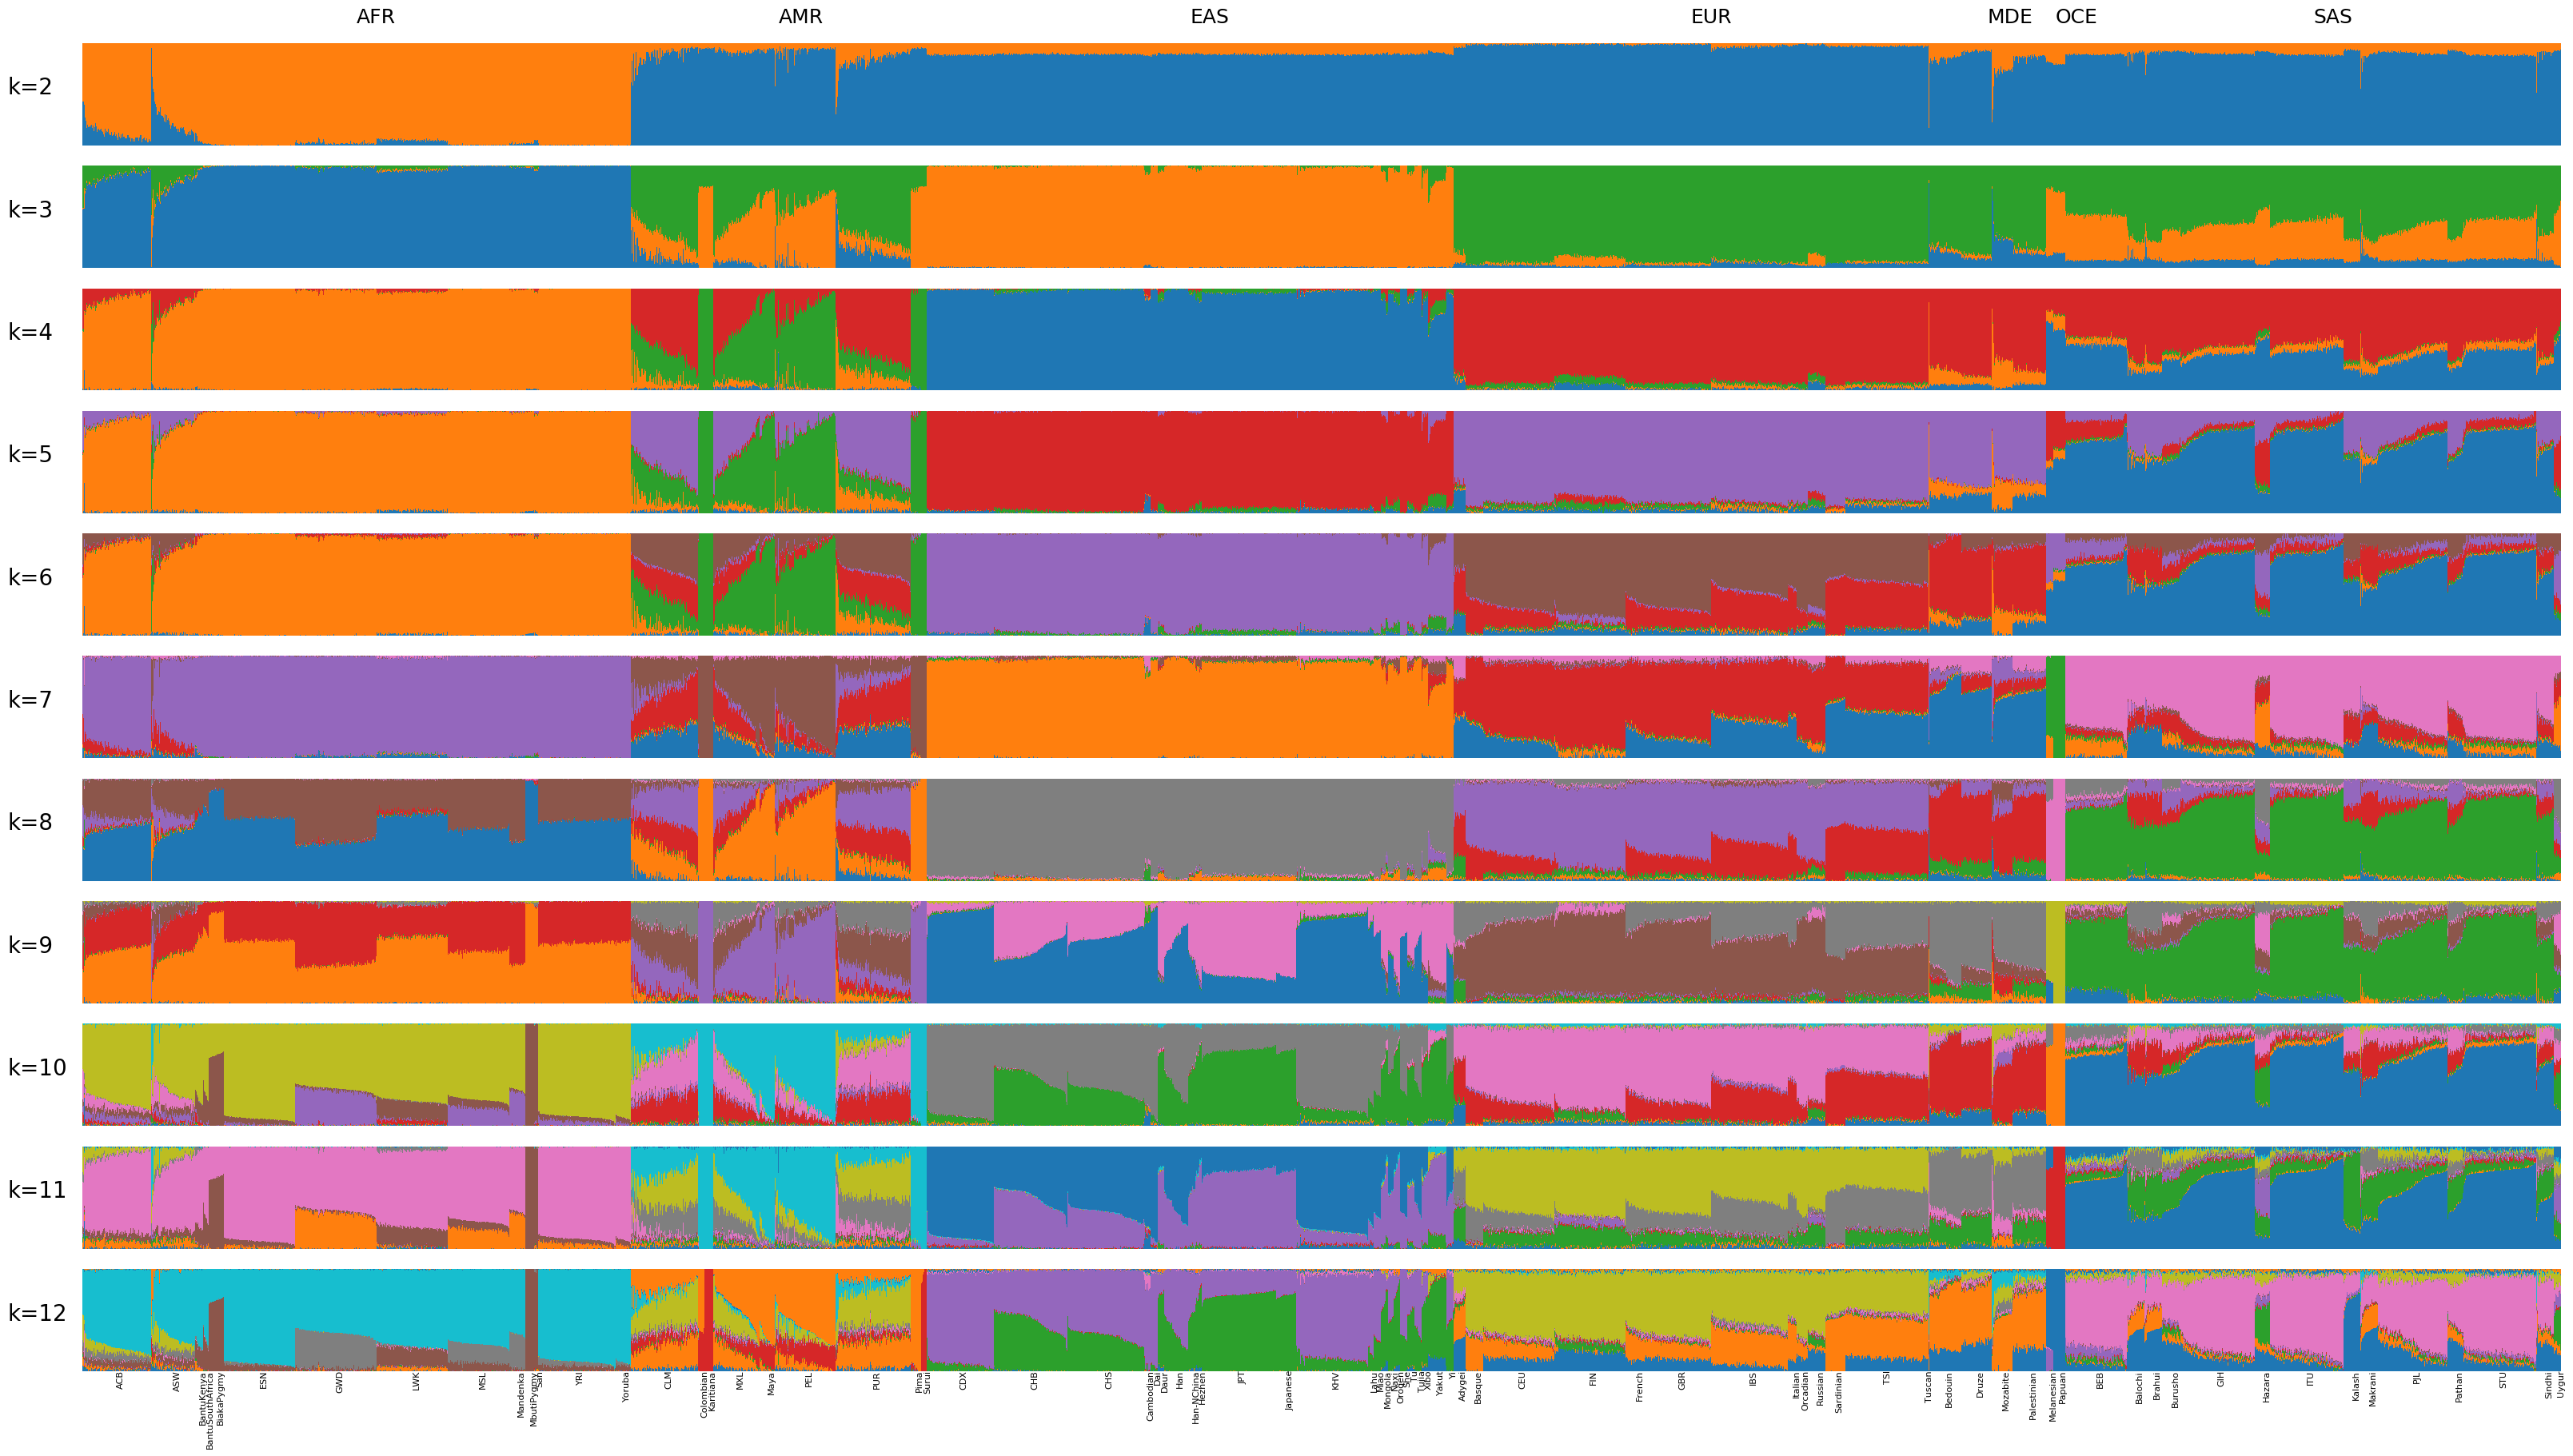

In [4]:
plot_admix(admix_ref,  new_pop_ref)
#plt.show() #show or save
plt.savefig("Figures/Admixture_reference.png")

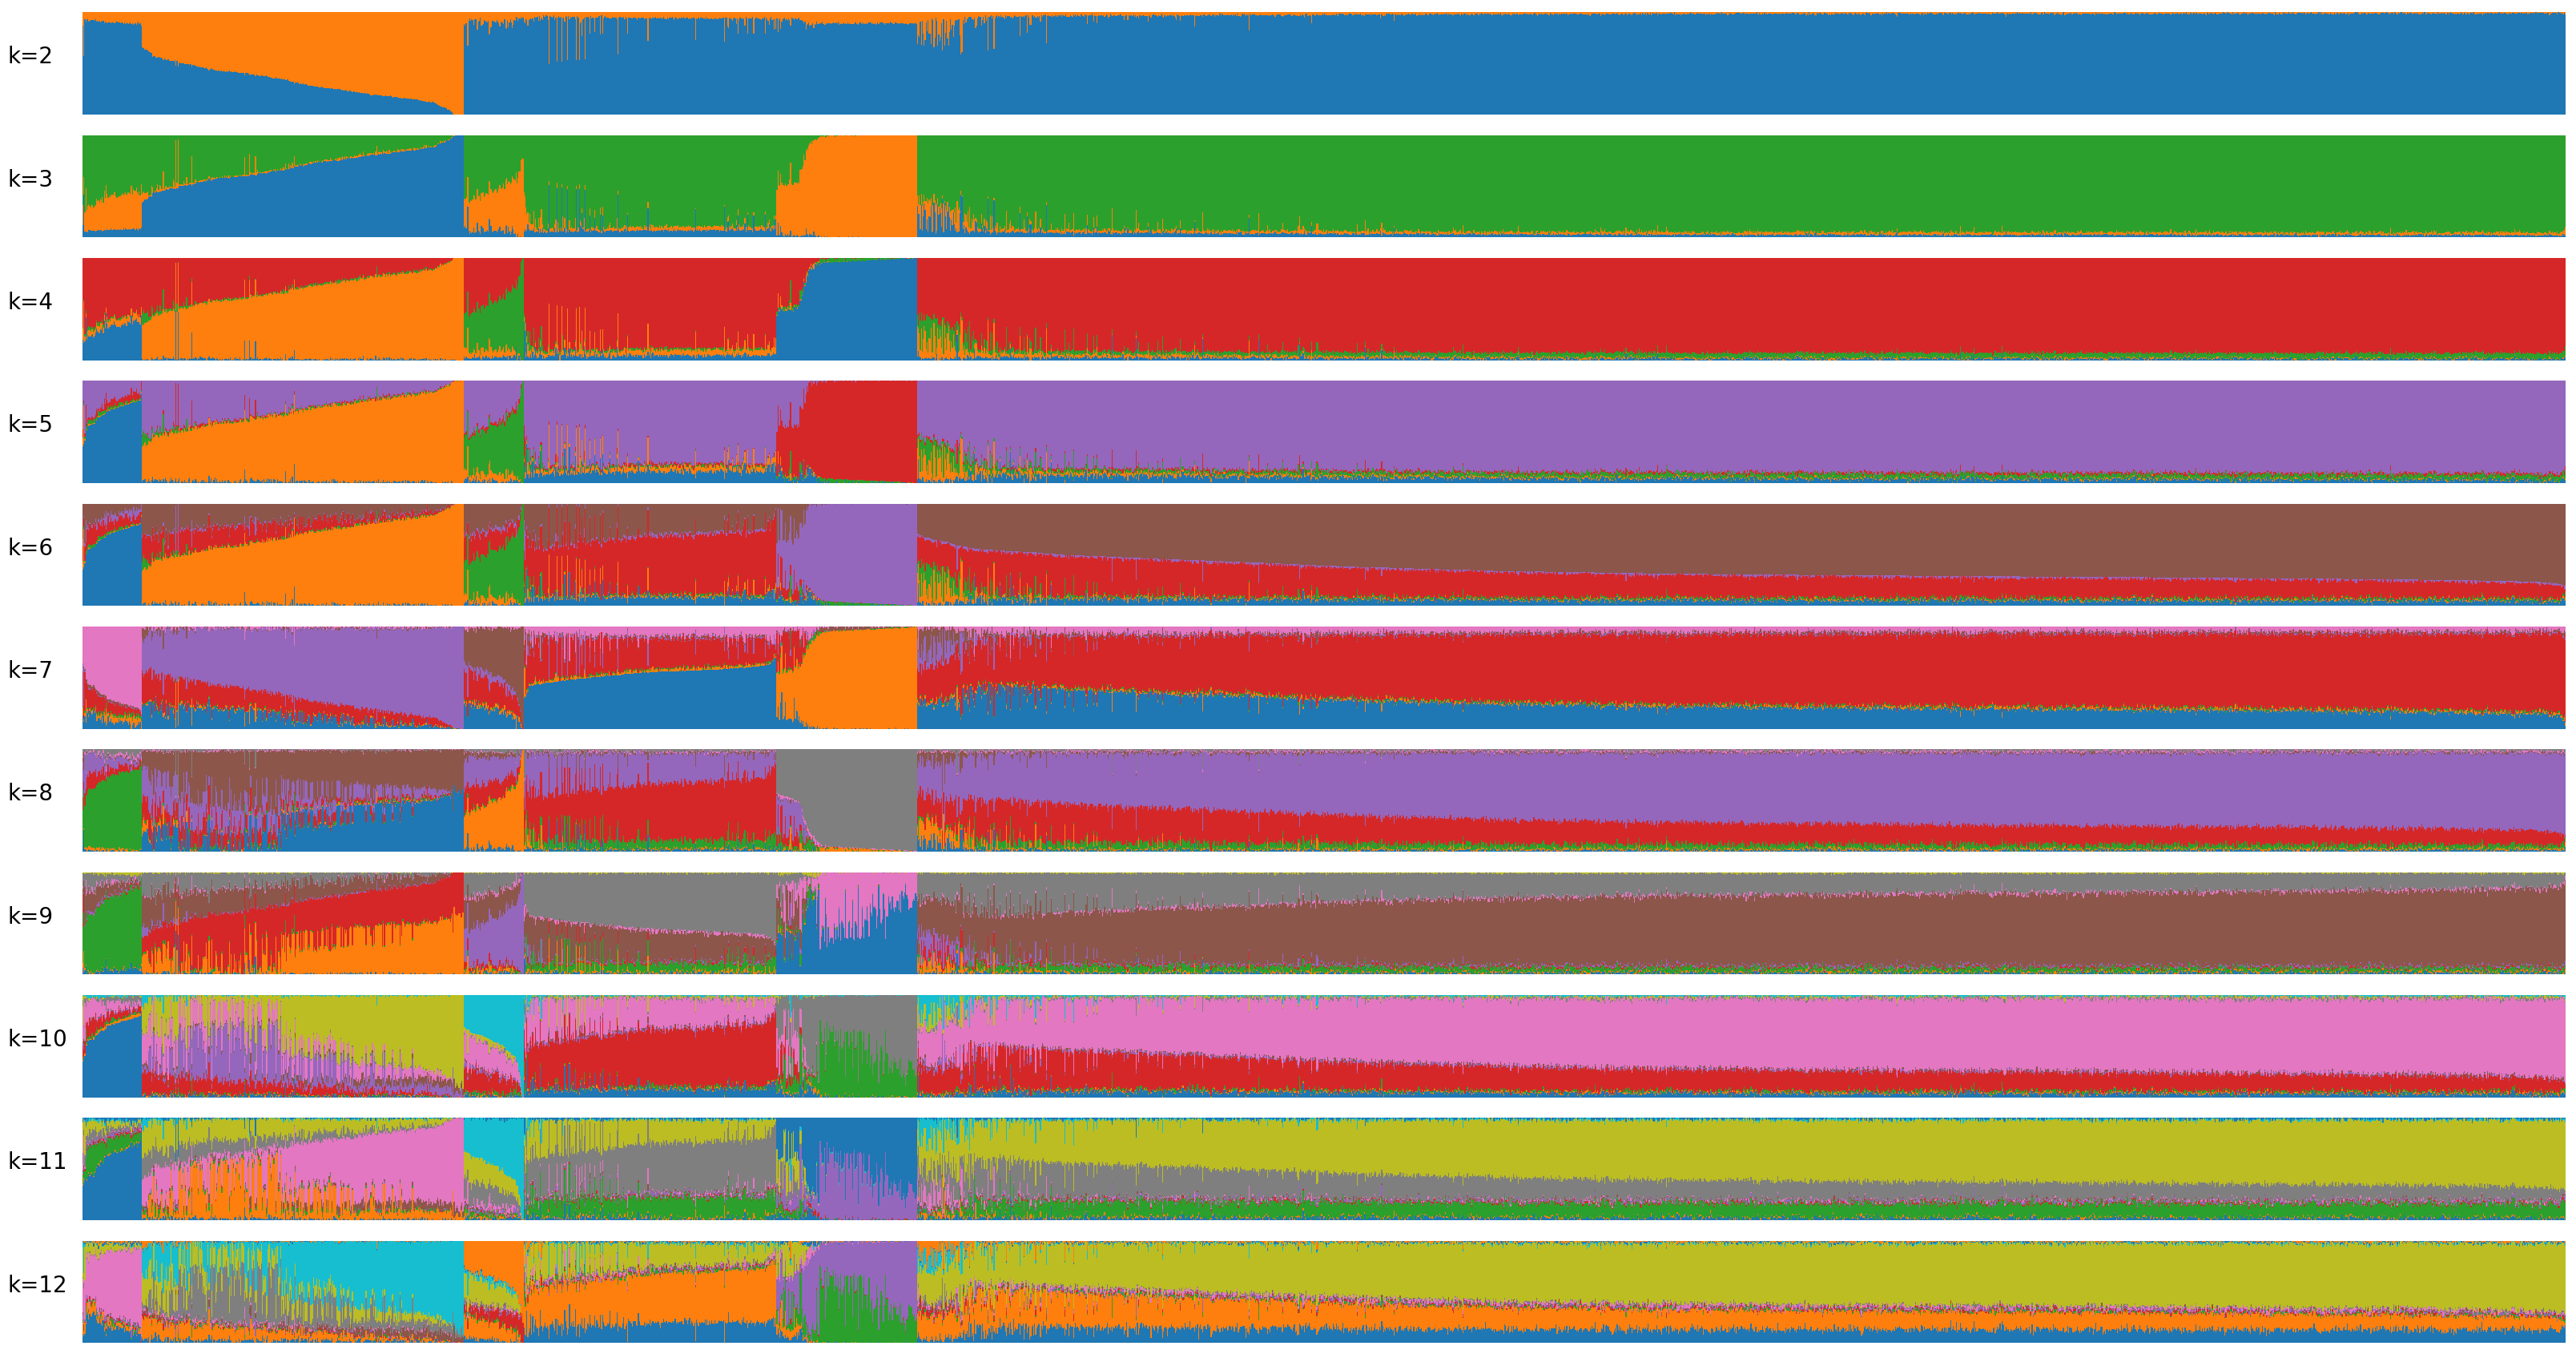

In [5]:
plot_admix(admix_adapt, sort_by_k=4)
#plt.show() #show or save
plt.savefig("Figures/Admixture_adapt.png")